# 0. 네이버 블로그 크롤링 위한 준비

In [1]:
import re
import json
import math
import requests
import urllib.request
import urllib.error
import urllib.parse
from bs4 import BeautifulSoup
import pandas as pd

naver_client_id = "OnWRZS9VM4NjQ0wJGo2q"
naver_client_secret = "Sj9k_A_HxT"

def get_blog_count(query, display):
    encode_query = urllib.parse.quote(query)
    search_url = "https://openapi.naver.com/v1/search/blog?query=" + encode_query
    request = urllib.request.Request(search_url)

    request.add_header("X-Naver-Client-Id", naver_client_id)
    request.add_header("X-Naver-Client-Secret", naver_client_secret)

    response = urllib.request.urlopen(request)
    response_code = response.getcode()

    if response_code is 200:
        response_body = response.read()
        response_body_dict = json.loads(response_body.decode('utf-8'))

        print("Last build date: " + str(response_body_dict['lastBuildDate']))
        print("Total: " + str(response_body_dict['total']))
        print("Start: " + str(response_body_dict['start']))
        print("Display: " + str(response_body_dict['display']))

        if response_body_dict['total'] == 0:
            blog_count = 0
        else:
            blog_total = math.ceil(response_body_dict['total'] / int(display))

            if blog_total >= 1000:
                blog_count = 1000
            else:
                blog_count = blog_total

            print("Blog total: " + str(blog_total))
            print("Blog count: " + str(blog_count))

        return blog_count

def get_blog_post(query, display, start_index, sort):
    global no, df
    
    encode_query = urllib.parse.quote(query)
    search_url = "https://openapi.naver.com/v1/search/blog?query=" + encode_query + "&display=" + str(display) + "&start=" + str(start_index) + "&sort=" + sort

    request = urllib.request.Request(search_url)

    request.add_header("X-Naver-Client-Id", naver_client_id)
    request.add_header("X-Naver-Client-Secret", naver_client_secret)

    response = urllib.request.urlopen(request)
    response_code = response.getcode()

    if response_code is 200:
        response_body = response.read()
        response_body_dict = json.loads(response_body.decode('utf-8'))
        for item_index in range(0, len(response_body_dict['items'])):
            try:
                remove_html_tag = re.compile('<.*?>')
                title = re.sub(remove_html_tag, '', response_body_dict['items'][item_index]['title'])
                link = response_body_dict['items'][item_index]['link'].replace("amp;", "")
                description = re.sub(remove_html_tag, '', response_body_dict['items'][item_index]['description'])
                blogger_name = response_body_dict['items'][item_index]['bloggername']
                blogger_link = response_body_dict['items'][item_index]['bloggerlink']
                post_date = response_body_dict['items'][item_index]['postdate']

                no += 1
                post_code = requests.get(link)
                post_text = post_code.text
                post_soup = BeautifulSoup(post_text, 'lxml')

                blog_post_content_text = ""
                for mainFrame in post_soup.select('iframe#mainFrame'):
                    blog_post_url = "http://blog.naver.com" + mainFrame.get('src')
                    blog_post_code = requests.get(blog_post_url)
                    blog_post_text = blog_post_code.text
                    blog_post_soup = BeautifulSoup(blog_post_text, 'lxml')
                    
                    for blog_post_content in blog_post_soup.find_all('div', class_='se-viewer'):
                        blog_post_content_text = blog_post_content.get_text()
                        
                    for blog_post_content in blog_post_soup.find_all('div', class_='se_doc_viewer'):
                        blog_post_content_text = blog_post_content.get_text()
 
                    for blog_post_content in blog_post_soup.select('div#postViewArea'):
                        blog_post_content_text = blog_post_content.get_text()

                df.loc[no] = [title, link, description, blogger_name, blogger_link, post_date, blog_post_content_text]
                print("#", end='')
                
            except:
                item_index += 1

<>:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:63: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:63: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-1-4ae7e6133ec0>:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if response_code is 200:
<ipython-input-1-4ae7e6133ec0>:63: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if response_code is 200:


# 2. 제주도 카페거리

## (1) "제주도 카페거리"검색결과 네이버 블로그 크롤링(.csv) 후 DataFrame에 저장

In [20]:
no = 0                 # 몇개의 포스트를 저장하였는지 세기 위한 index
query = "제주도 카페거리"   # 검색을 원하는 문자열로서 UTF-8로 인코딩한다.
display = 10           # 검색 결과 출력 건수 지정, 10(기본값),100(최대)
start = 1              # 검색 시작 위치로 최대 1000까지 가능
sort = "sim"           # 정렬 옵션: sim(유사도순, 기본값), date(날짜순)

# 블로그를 DataFrame에 저장
df = pd.DataFrame(columns=("Title", "Link", "Description", "Blogger Name", "Blogger Link", "Post Date", "Post Contents"))

blog_count = get_blog_count(query, display)
for start_index in range(start, blog_count + 1, display):
    get_blog_post(query, display, start_index, sort)

df.to_csv("./data/data_제주도_카페거리.csv", header=True, index=False)

Last build date: Mon, 23 Aug 2021 16:32:09 +0900
Total: 288484
Start: 1
Display: 10
Blog total: 28849
Blog count: 1000
#################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

In [188]:
import pandas as pd
import re
import networkx as nx

df = pd.read_csv('./data/data_제주도_카페거리.csv', encoding='utf-8')
posts = df.get('Title') + " " + df.get('Description')
post_date = df.get('Post Date')

## (2) 불용어 제거, 명사 추출, 빈도수 높은 명사 추출(top_nouns)

In [189]:
# 불용어 제거
from eunjeon import Mecab
tagger = Mecab()

stop_words = "아 휴 아이구 아이쿠 아이고 어 나 우리 저희 따라 의해 을 를 에 의 가 으로 로 에게 뿐이다 의거하여 근거하여 입각하여 기준으로 예하면 예를 들면 예를 들자면 저 소인 소생 저희 지말고 하지마 하지마라 다른 물론 또한 그리고 비길수 없다 해서는 안된다 뿐만 아니라 만이 아니다 만은 아니다 막론하고 관계없이 그치지 않다 그러나 그런데 하지만 든간에 논하지 않다 따지지 않다 설사 비록 더라도 아니면 만 못하다 하는 편이 낫다 불문하고 향하여 향해서 향하다 쪽으로 틈타 이용하여 타다 오르다 제외하고 이 외에 이 밖에 하여야 비로소 한다면 몰라도 외에도 이곳 여기 부터 기점으로 따라서 할 생각이다 하려고하다 이리하여 그리하여 그렇게 함으로써 하지만 일때 할때 앞에서 중에서 보는데서 으로써 로써 까지 해야한다 일것이다 반드시 할줄알다 할수있다 할수있어 임에 틀림없다 한다면 등 등등 제 겨우 단지 다만 할뿐 딩동 댕그 대해서 대하여 대하면 훨씬 얼마나 얼마만큼 얼마큼 남짓 여 얼마간 약간 다소 좀 조금 다수 몇 얼마 지만 하물며 또한 그러나 그렇지만 하지만 이외에도 대해 말하자면 뿐이다 다음에 반대로 반대로 말하자면 이와 반대로 바꾸어서 말하면 바꾸어서 한다면 만약 그렇지않으면 까악 툭 딱 삐걱거리다 보드득 비걱거리다 꽈당 응당 해야한다 에 가서 각 각각 여러분 각종 각자 제각기 하도록하다 와 과 그러므로 그래서 고로 한 까닭에 하기 때문에 거니와 이지만 대하여 관하여 관한 과연 실로 아니나다를가 생각한대로 진짜로 한적이있다 하곤하였다 하 하하 허허 아하 거바 와 오 왜 어째서 무엇때문에 어찌 하겠는가 무슨 어디 어느곳 더군다나 하물며 더욱이는 어느때 언제 야 이봐 어이 여보시오 흐흐 흥 휴 헉헉 헐떡헐떡 영차 여차 어기여차 끙끙 아야 앗 아야 콸콸 졸졸 좍좍 뚝뚝 주룩주룩 솨 우르르 그래도 또 그리고 바꾸어말하면 바꾸어말하자면 혹은 혹시 답다 및 그에 따르는 때가 되어 즉 지든지 설령 가령 하더라도 할지라도 일지라도 지든지 몇 거의 하마터면 인젠 이젠 된바에야 된이상 만큼 어찌됏든 그위에 게다가 점에서 보아 비추어 보아 고려하면 하게될것이다 일것이다 비교적 좀 보다더 비하면 시키다 하게하다 할만하다 의해서 연이서 이어서 잇따라 뒤따라 뒤이어 결국 의지하여 기대여 통하여 자마자 더욱더 불구하고 얼마든지 마음대로 주저하지 않고 곧 즉시 바로 당장 하자마자 밖에 안된다 하면된다 그래 그렇지 요컨대 다시 말하자면 바꿔 말하면 즉 구체적으로 말하자면 시작하여 시초에 이상 허 헉 허걱 바와같이 해도좋다 해도된다 게다가 더구나 하물며 와르르 팍 퍽 펄렁 동안 이래 하고있었다 이었다 에서 로부터 까지 예하면 했어요 해요 함께 같이 더불어 마저 마저도 양자 모두 습니다 가까스로 하려고하다 즈음하여 다른 다른 방면으로 해봐요 습니까 했어요 말할것도 없고 무릎쓰고 개의치않고 하는것만 못하다 하는것이 낫다 매 매번 들 모 어느것 어느 로써 갖고말하자면 어디 어느쪽 어느것 어느해 어느 년도 라 해도 언젠가 어떤것 어느것 저기 저쪽 저것 그때 그럼 그러면 요만한걸 그래 그때 저것만큼 그저 이르기까지 할 줄 안다 할 힘이 있다 너 너희 당신 어찌 설마 차라리 할지언정 할지라도 할망정 할지언정 구토하다 게우다 토하다 메쓰겁다 옆사람 퉤 쳇 의거하여 근거하여 의해 따라 힘입어 그 다음 버금 두번째로 기타 첫번째로 나머지는 그중에서 견지에서 형식으로 쓰여 입장에서 위해서 단지 의해되다 하도록시키다 뿐만아니라 반대로 전후 전자 앞의것 잠시 잠깐 하면서 그렇지만 다음에 그러한즉 그런즉 남들 아무거나 어찌하든지 같다 비슷하다 예컨대 이럴정도로 어떻게 만약 만일 위에서 서술한바와같이 인 듯하다 하지 않는다면 만약에 무엇 무슨 어느 어떤 아래윗 조차 한데 그럼에도 불구하고 여전히 심지어 까지도 조차도 하지 않도록 않기 위하여 때 시각 무렵 시간 동안 어때 어떠한 하여금 네 예 우선 누구 누가 알겠는가 아무도 줄은모른다 줄은 몰랏다 하는 김에 겸사겸사 하는바 그런 까닭에 한 이유는 그러니 그러니까 때문에 그 너희 그들 너희들 타인 것 것들 너 위하여 공동으로 동시에 하기 위하여 어찌하여 무엇때문에 붕붕 윙윙 나 우리 엉엉 휘익 윙윙 오호 아하 어쨋든 만 못하다 하기보다는 차라리 하는 편이 낫다 흐흐 놀라다 상대적으로 말하자면 마치 아니라면 쉿 그렇지 않으면 그렇지 않다면 안 그러면 아니었다면 하든지 아니면 이라면 좋아 알았어 하는것도 그만이다 어쩔수 없다 하나 일 일반적으로 일단 한켠으로는 오자마자 이렇게되면 이와같다면 전부 한마디 한항목 근거로 하기에 아울러 하지 않도록 않기 위해서 이르기까지 이 되다 로 인하여 까닭으로 이유만으로 이로 인하여 그래서 이 때문에 그러므로 그런 까닭에 알 수 있다 결론을 낼 수 있다 으로 인하여 있다 어떤것 관계가 있다 관련이 있다 연관되다 어떤것들 에 대해 이리하여 그리하여 여부 하기보다는 하느니 하면 할수록 운운 이러이러하다 하구나 하도다 다시말하면 다음으로 에 있다 에 달려 있다 우리 우리들 오히려 하기는한데 어떻게 어떻해 어찌됏어 어때 어째서 본대로 자 이 이쪽 여기 이것 이번 이렇게말하자면 이런 이러한 이와 같은 요만큼 요만한 것 얼마 안 되는 것 이만큼 이 정도의 이렇게 많은 것 이와 같다 이때 이렇구나 것과 같이 끼익 삐걱 따위 와 같은 사람들 부류의 사람들 왜냐하면 중의하나 오직 오로지 에 한하다 하기만 하면 도착하다 까지 미치다 도달하다 정도에 이르다 할 지경이다 결과에 이르다 관해서는 여러분 하고 있다 한 후 혼자 자기 자기집 자신 우에 종합한것과같이 총적으로 보면 총적으로 말하면 총적으로 대로 하다 으로서 참 그만이다 할 따름이다 쿵 탕탕 쾅쾅 둥둥 봐 봐라 아이야 아니 와아 응 아이 참나 년 월 일 령 영 일 이 삼 사 오 육 륙 칠 팔 구 이천육 이천칠 이천팔 이천구 하나 둘 셋 넷 다섯 여섯 일곱 여덟 아홉 령 영 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 놓 "
stop_words = stop_words.split(' ')
stop_words[0:10]

# 명사 추출
nouns = []
for post in posts:
    for noun in tagger.nouns(post):
        if noun not in stop_words:
            nouns.append(noun)
            
nouns[0:10]

# 빈도수 높은 명사 추출 (top_nouns)
from collections import Counter
num_top_nouns = 40 ########################################################################
nouns_counter = Counter(nouns)
top_nouns = dict(nouns_counter.most_common(num_top_nouns))
top_nouns

{'카페': 3116,
 '제주도': 2314,
 '거리': 1461,
 '애월': 1170,
 '제주': 949,
 '여행': 575,
 '곳': 370,
 '월정리': 201,
 '이중섭': 196,
 '바다': 192,
 '맛집': 192,
 '해변': 188,
 '분': 169,
 '두기': 165,
 '커피': 158,
 '단계': 155,
 '추천': 154,
 '차': 146,
 '서귀포': 140,
 '날': 139,
 '뷰': 137,
 '위치': 132,
 '시': 126,
 '사진': 113,
 '드': 112,
 '박': 110,
 '도넛': 109,
 '한담': 105,
 '핫': 103,
 '해수욕장': 102,
 '봄날': 99,
 '식당': 97,
 '코스': 92,
 '노티': 91,
 '해안': 88,
 '유명': 83,
 '몽': 80,
 '상드': 80,
 '영업': 78,
 '근처': 74}

## (3) 블로그 내용을 문장으로 나누기
블로그 내용에 대해서 문장으로 나누기 위해서 문장의 끝을 나타내는 ';', '.','?', '!' 를 구분자로 사용한다.

In [190]:
sentences = []
for post in posts:
    sentences.extend(re.split('; |\.|\?|\!', post))
sentences[0:10]

['로망을 실현하는 제주도 애월 카페거리 로망을 실현하는 제주도 애월 카페거리 매년 한번씩 각 지역의 이름난 카페투어를 다니곤하는데요',
 ' 이번에 제가 다녀온 제주도 애월 카페거리 중에서도 가장 핫한 곳들만 담아 후기를 남겨보려고합니다',
 ' 1',
 '',
 '',
 '',
 ' ',
 '3월 제주도 여행 4박 5일 마지막 날 ( 단소 식당, 애월  카페거리) 5일째 단소 식당-&gt;애월 카페거리, 투썸플레이스-&gt;공항 제주도 마지막 날 아침입니다',
 ' 초반엔 시간이 느리게 흐르는 것 같았으나 나름 길게 잡았던 4박 5일도 금방 지나가버렸습니다',
 ' 이날은 날씨가 가장']

## (4) 문장별 명사 추출
블로그 내용을 문장별로 구분하였고, 구분된 문장 별로 명사를 추출하여 정리한다.

In [191]:
sentences_nouns = []
for sentence in sentences:
    sentence_nouns = tagger.nouns(sentence)
    sentences_nouns.append(sentence_nouns)
sentences_nouns[0:10]

[['로망',
  '실현',
  '제주도',
  '애월',
  '카페',
  '거리',
  '로망',
  '실현',
  '제주도',
  '애월',
  '카페',
  '거리',
  '번',
  '지역',
  '카페',
  '투어'],
 ['이번', '제', '제주도', '애월', '카페', '거리', '중', '핫', '곳', '후기'],
 [],
 [],
 [],
 [],
 [],
 ['월',
  '제주도',
  '여행',
  '박',
  '일',
  '마지막',
  '날',
  '단소',
  '식당',
  '애월',
  '카페',
  '거리',
  '일',
  '단소',
  '식당',
  '애월',
  '카페',
  '거리',
  '투썸',
  '플레이스',
  '공항',
  '제주도',
  '마지막',
  '날',
  '아침'],
 ['초반', '시간', '것', '나름', '박', '일'],
 ['이날', '날씨']]

## (5) 당연하거나 여행과 관련 없는 단어들 제거

In [192]:
del top_nouns['제주도']
del top_nouns['거리']
del top_nouns['제주']
del top_nouns['곳']
del top_nouns['분']
del top_nouns['두기']
del top_nouns['단계']
del top_nouns['차']
del top_nouns['날']
del top_nouns['시']
del top_nouns['드']
del top_nouns['박']
del top_nouns['핫']
del top_nouns['코스']
del top_nouns['해안']
del top_nouns['영업']

del top_nouns['애월']
del top_nouns['여행']
del top_nouns['월정리']
del top_nouns['추천']
del top_nouns['한담']
del top_nouns['서귀포']

del top_nouns['해변']
del top_nouns['바다']

top_nouns

{'카페': 3116,
 '이중섭': 196,
 '맛집': 192,
 '커피': 158,
 '뷰': 137,
 '위치': 132,
 '사진': 113,
 '도넛': 109,
 '해수욕장': 102,
 '봄날': 99,
 '식당': 97,
 '노티': 91,
 '유명': 83,
 '몽': 80,
 '상드': 80,
 '근처': 74}

## (6) 상위 단어에 대해 id 적용
- 상위 단어 top_nouns에 대해서 key에 해당하는 단어, value에 해당하는 id를 넣어 딕셔너리 형태 (word2id)로 저장한다.
- 상위 단어 top_nouns에 대해서 key에 해당하는 id, value에 해당하는 단어를 넣어 딕셔너리 형태 (id2word)로 저장한다.

In [193]:
word2id = {w: i for i, w in enumerate(top_nouns.keys())}
word2id

id2word = {i: w for i, w in enumerate(top_nouns.keys())}
id2word

{0: '카페',
 1: '이중섭',
 2: '맛집',
 3: '커피',
 4: '뷰',
 5: '위치',
 6: '사진',
 7: '도넛',
 8: '해수욕장',
 9: '봄날',
 10: '식당',
 11: '노티',
 12: '유명',
 13: '몽',
 14: '상드',
 15: '근처'}

## (7) 인접행렬 생성
상위 단어들에 대해서 상위 갯수만큼의 인접행렬을 만들고, 문장 내에 상위 단어가 함께 포함된 비중에 따라 가중치를 계산하여 행렬에 표현한다. 인접 행렬을 생성하기 위해서 이전에 생성해둔 word2id를 이용한다. 행렬에서 만약 가중치가 0 이상이면 서로 연결되어 있음을 의미한다.

In [194]:
# weight -> 한 문장 안에서 같이 나온 단어들의 빈도수
import numpy as np
adjacent_matrix = np.zeros((len(top_nouns), len(top_nouns)), int) #zeros -> 0으로 가득 찬 array 생성
for sentence in sentences_nouns:
    for wi, i in word2id.items(): #key, value 둘 다 동시에 사용중 (wi가 key, i가 value)
        if wi in sentence:
            for wj, j in word2id.items():
                if i != j and wj in sentence:
                    adjacent_matrix[i][j] += 1
adjacent_matrix

array([[  0,  97, 115,  94,  98,  93,  76,  59,  71,  71,  74,  57,  69,
         58,  58,  58],
       [ 97,   0,   5,  32,   0,  15,   2,   0,   1,   2,   2,   0,   5,
          0,   0,   8],
       [115,   5,   0,   7,  16,   6,   8,  10,   8,   5,   1,   8,   6,
          6,   6,   1],
       [ 94,  32,   7,   0,   7,   9,   7,   0,   2,   3,   1,   1,   5,
          2,   2,   7],
       [ 98,   0,  16,   7,   0,   1,   7,   1,   3,   4,   0,   1,   2,
          3,   3,   4],
       [ 93,  15,   6,   9,   1,   0,   4,   5,   3,   7,   1,   7,  10,
          3,   3,   8],
       [ 76,   2,   8,   7,   7,   4,   0,   0,   2,   2,   0,   1,   3,
          1,   1,   3],
       [ 59,   0,  10,   0,   1,   5,   0,   0,   0,   5,   0,  38,   5,
          5,   5,   3],
       [ 71,   1,   8,   2,   3,   3,   2,   0,   0,   3,   4,   3,   2,
          2,   2,   2],
       [ 71,   2,   5,   3,   4,   7,   2,   5,   3,   0,   1,   8,   7,
         12,  12,   4],
       [ 74,   2,   1,   1,   

In [195]:
df = pd.DataFrame(adjacent_matrix, index=word2id.keys(), columns=word2id.keys())

import seaborn as sns
cm = sns.light_palette("skyblue", as_cmap=True)
df.style.background_gradient(cmap=cm)

,카페,이중섭,맛집,커피,뷰,위치,사진,도넛,해수욕장,봄날,식당,노티,유명,몽,상드,근처
카페,0,97,115,94,98,93,76,59,71,71,74,57,69,58,58,58
이중섭,97,0,5,32,0,15,2,0,1,2,2,0,5,0,0,8
맛집,115,5,0,7,16,6,8,10,8,5,1,8,6,6,6,1
커피,94,32,7,0,7,9,7,0,2,3,1,1,5,2,2,7
뷰,98,0,16,7,0,1,7,1,3,4,0,1,2,3,3,4
위치,93,15,6,9,1,0,4,5,3,7,1,7,10,3,3,8
사진,76,2,8,7,7,4,0,0,2,2,0,1,3,1,1,3
도넛,59,0,10,0,1,5,0,0,0,5,0,38,5,5,5,3
해수욕장,71,1,8,2,3,3,2,0,0,3,4,3,2,2,2,2
봄날,71,2,5,3,4,7,2,5,3,0,1,8,7,12,12,4


## (8) 인접행렬에 대해 네트워크 생성
인접행렬에 대해서 네트워크를 만들고, 네트워크에 포함된 인접행렬에 대한 결과를 살펴본다.

In [196]:
network = nx.from_numpy_matrix(adjacent_matrix)
list(network.adjacency())

[(0,
  {1: {'weight': 97},
   2: {'weight': 115},
   3: {'weight': 94},
   4: {'weight': 98},
   5: {'weight': 93},
   6: {'weight': 76},
   7: {'weight': 59},
   8: {'weight': 71},
   9: {'weight': 71},
   10: {'weight': 74},
   11: {'weight': 57},
   12: {'weight': 69},
   13: {'weight': 58},
   14: {'weight': 58},
   15: {'weight': 58}}),
 (1,
  {0: {'weight': 97},
   2: {'weight': 5},
   3: {'weight': 32},
   5: {'weight': 15},
   6: {'weight': 2},
   8: {'weight': 1},
   9: {'weight': 2},
   10: {'weight': 2},
   12: {'weight': 5},
   15: {'weight': 8}}),
 (2,
  {0: {'weight': 115},
   1: {'weight': 5},
   3: {'weight': 7},
   4: {'weight': 16},
   5: {'weight': 6},
   6: {'weight': 8},
   7: {'weight': 10},
   8: {'weight': 8},
   9: {'weight': 5},
   10: {'weight': 1},
   11: {'weight': 8},
   12: {'weight': 6},
   13: {'weight': 6},
   14: {'weight': 6},
   15: {'weight': 1}}),
 (3,
  {0: {'weight': 94},
   1: {'weight': 32},
   2: {'weight': 7},
   4: {'weight': 7},
   5: {'we

## (9) 시각화
생성된 네트워크에 대해서 데이터를 시각화하여 나타낸다. 여기서 labels 값으로 이전에 생성한 id2word를 이용한다.

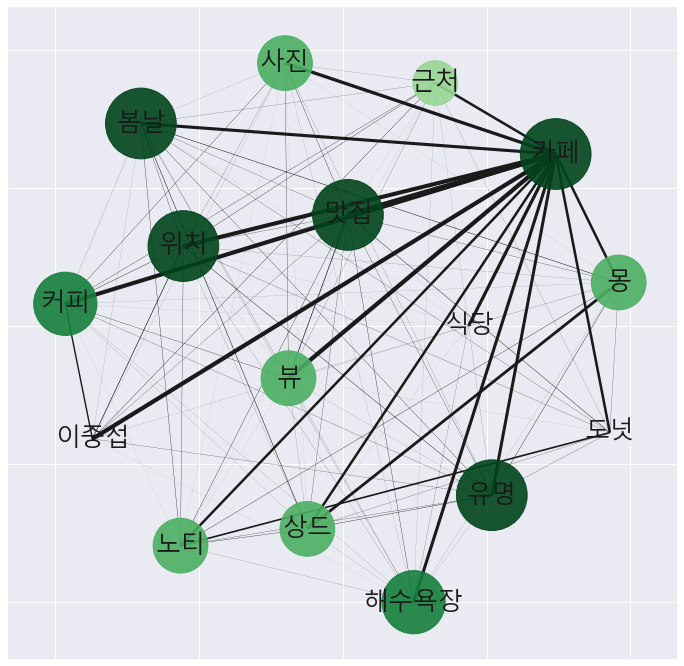

In [236]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
#
import seaborn as sns

sns.set(rc = {'figure.figsize':(10,6)})
plt.rc('font', family=font_name)

def get_node_size(node_values):
    nsize=np.array([v for v in node_values])
    nsize = 5000*(nsize-min(nsize))/(max(nsize)-min(nsize))
    
    return nsize

dc = nx.degree_centrality(network).values()

nodes=list(top_nouns.keys())
graph = nx.Graph()
graph.add_nodes_from(nodes)
mat = adjacent_matrix

for row, row_val in enumerate(nodes):
    for col, col_val in enumerate(nodes):
        if col > row: 
            graph.add_edge(row_val, col_val, weighT1231=mat[row, col])

# Choose a layout to visualize graph
pos = nx.spring_layout(graph)
edges = graph.edges()

# Get the edge weights and normalize them 
weights = [abs(graph[u][v]['weighT1231']) for u, v in edges]
weights_n = [5*float(i)/max(weights) for i in weights] # Change 5 to control thickness

# First draw the nodes 
plt.figure(figsize=(12,12))

nx.draw_networkx_nodes(graph, pos=pos, nodelist=nodes,node_color = list(dc),alpha=0.9, node_size = get_node_size(dc), cmap=plt.cm.Greens)
nx.draw_networkx_edges(graph, pos=pos, width=weights_n)
nx.draw_networkx_labels(graph, font_family=font_name, font_size=25, pos=pos, font_color='k')
plt.show()